# Deep Learning - Recursive Neural Network (RNN), Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) regression models

## 1. Introduction

Recurrent Neural Networks are a deep learning architecture capable of handling the sequential property in time series data unlike traditional feedforward neural networks. The latter takes the input data points as independent without considering correlations between them, and activations flow only in one direction from the input to the output layer. RNNs look like this but also have connections pointing backward.

A simple RNN model will be trained on AstraZeneca stock data followed by LSTM and GRU models which were developed to overcome the vanishing gradient problem. Results will be compared.

## 2. Install/import libraries

In [ ]:
!pip install yfinance as yfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
from datetime import date, timedelta
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

## 3. Download data

Download AstraZeneca historical data for 2010-2020 from Yahoo! Finance.

In [ ]:
azn_df = yf.download("AZN.L", start="1994-01-02", end=str(date.today()))[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
azn_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
1994-01-03,304.96,820.13,820.13,820.13,820.13,0
1994-01-04,304.05,817.69,817.69,817.69,817.69,0
1994-01-05,301.88,811.84,811.84,811.84,811.84,0
1994-01-06,307.68,827.45,827.45,827.45,827.45,0
1994-01-07,313.12,842.09,842.09,842.09,842.09,0
...,...,...,...,...,...,...
2023-09-29,11102.00,11046.00,11234.00,11020.00,11102.00,1752888
2023-10-02,10950.00,11060.00,11188.00,10870.00,10950.00,3816373
2023-10-03,10908.00,10996.00,11070.00,10884.00,10908.00,1297146


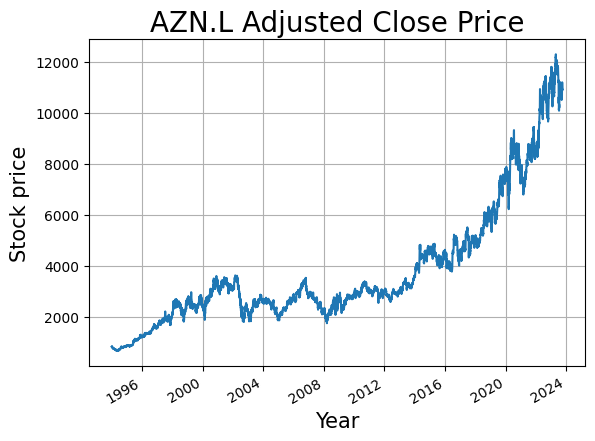

In [ ]:
# Plot Adjusted Close price

azn_df['Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## 4. Creating the Training and Test data

Generating multiple input and output data for model training as a  many-to-many data structure will enable us to forecast several time steps in the future. We will use the prices of the past X days to forecast those of the future Y days. In this example we will use the prices of the past 5 days (multiple inputs of 5 data points) to forecast the prices of the next 2 days (multiple outputs of 2 data points).

**Samples** are created from the univariate time series and each sample has 5 inputs and 2 outputs. Each input of a sample is called the **time step**, and each time step has one **feature**, the Adjusted Close price.

The function below:
1.   creates a training set using 70% of the data and a test set using 30%.
2.   normalises the training data by converting the values of numeric columns in the dataset to a common scale, which helps the performance of the model. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1.
3. creates many-to-many input and output data structure for training and converts to numpy arrays for modelling.
4. reshapes the X_train data to a 3-D array with samples, time steps and feature dimensions
5. creates X_test data, converts to a numpy array and reshapes to 3-D array



In [ ]:
# standardise data to train model - only the training data are used to fit the scaler transformation
# then the scaler is used to transform the test input data

def ts_train_test(data,time_steps,for_periods):

    # Create training and test set
    ts_train = azn_df[:'2016'].iloc[:,0:1].values
    ts_test  = azn_df['2017':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling - data normalisation - only the training data are used to fit the scaler transformation
    # MinMaxScaler scales all the data to be between 0 and 1.
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convert X_train and y_train to numpy arrays for training
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train to 3-D array of samples, time steps and features for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((azn_df["Adj Close"][:'2016'], azn_df["Adj Close"]['2017':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Creating X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    # Convert X_test to numpy array
    X_test = np.array(X_test)
    # Reshape X_test to be 3-D
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

X_train, y_train, X_test, sc = ts_train_test(azn_df,5,2) # Each sample row in X_train has 5 inputs and y_train has 2 outputs
X_train.shape[0],X_train.shape[1]                        # as we are using the prices of 5 days to forecast the prices of the next 2 days

(5904, 5)

In [ ]:
# Convert the 3-D shape of X_train and y_train to a data frame
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
pd.concat([X_train_df,y_train_df],axis=1)

,0,1,2,3,4,0,1
0,0.013910,0.013677,0.013120,0.014609,0.016006,0.016380,0.015728
1,0.013677,0.013120,0.014609,0.016006,0.016380,0.015728,0.014098
2,0.013120,0.014609,0.016006,0.016380,0.015728,0.014098,0.012468
3,0.014609,0.016006,0.016380,0.015728,0.014098,0.012468,0.013677
4,0.016006,0.016380,0.015728,0.014098,0.012468,0.013677,0.013772
...,...,...,...,...,...,...,...
5899,0.821916,0.841475,0.841681,0.821608,0.827372,0.823462,0.829637
5900,0.841475,0.841681,0.821608,0.827372,0.823462,0.829637,0.842915
5901,0.841681,0.821608,0.827372,0.823462,0.829637,0.842915,0.844975
5902,0.821608,0.827372,0.823462,0.829637,0.842915,0.844975,0.847034


X_train data is in columns 0-4 and y_train data is in columns 0-1

In [ ]:
# Convert the 3-D shape of X_test to a data frame
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_df)

,0,1,2,3,4
0,0.829637,0.842915,0.844975,0.847034,0.849195
1,0.842915,0.844975,0.847034,0.849195,0.849504
2,0.844975,0.847034,0.849195,0.849504,0.857224
3,0.847034,0.849195,0.849504,0.857224,0.872356
4,0.849195,0.849504,0.857224,0.872356,0.872459
...,...,...,...,...,...
1700,2.746975,2.730543,2.771622,2.809621,2.801918
1701,2.730543,2.771622,2.809621,2.801918,2.790108
1702,2.771622,2.809621,2.801918,2.790108,2.761353
1703,2.809621,2.801918,2.790108,2.761353,2.786000


In [ ]:
# Print number of samples
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 5904 samples in the training data
There are 1705 samples in the test data


##  5. Simple Recurrent Neural Network (RNN) model

In [ ]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    
    # The RNN architecture
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1],1)))
    my_rnn_model.add(SimpleRNN(32))
    # The output layer
    my_rnn_model.add(Dense(2)) # The time step of the output is 2

    # Compiling the RNN model
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # Fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

    # Make Predictions using the test set
    rnn_predictions = my_rnn_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions[1:10]

Epoch 1/200
185/185 [==============================] - 8s 11ms/step - loss: 0.0054
Epoch 2/200
185/185 [==============================] - 2s 13ms/step - loss: 0.0012
Epoch 3/200
185/185 [==============================] - 2s 11ms/step - loss: 7.3621e-04
Epoch 4/200
185/185 [==============================] - 3s 18ms/step - loss: 5.1057e-04
Epoch 5/200
185/185 [==============================] - 2s 11ms/step - loss: 4.0285e-04
Epoch 6/200
185/185 [==============================] - 2s 12ms/step - loss: 3.6148e-04
Epoch 7/200
185/185 [==============================] - 2s 11ms/step - loss: 3.0514e-04
Epoch 8/200
185/185 [==============================] - 2s 11ms/step - loss: 2.8161e-04
Epoch 9/200
185/185 [==============================] - 3s 17ms/step - loss: 2.5090e-04
Epoch 10/200
185/185 [==============================] - 2s 12ms/step - loss: 2.2813e-04
Epoch 11/200
185/185 [==============================] - 2s 11ms/step - loss: 2.0579e-04
Epoch 12/200
185/185 [===========================

array([[3537.9067, 3522.2886],
       [3567.896 , 3551.4387],
       [3623.8618, 3607.1094],
       [3622.1565, 3607.693 ],
       [3668.4453, 3652.0857],
       [3705.175 , 3688.7708],
       [3642.4941, 3628.877 ],
       [3630.042 , 3613.0469],
       [3670.1318, 3650.9392]], dtype=float32)

### Function to calculate MSE and plot actual vs predicted prices

In [ ]:
def actual_pred_plot(preds):
   
    # Create dataframe containing actual and predicted prices
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = azn_df.loc['2017':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    # Calculate mean squared error
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    print("MSE score:", m.result().numpy())

    # Plot actual vs predicted price
    sns.set(rc={'figure.figsize':(15, 9)})
    actual_pred.plot()
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
    plt.legend()

### Print MSE and plot Simple RNN model actual vs predictions

MSE score: 2789259.5


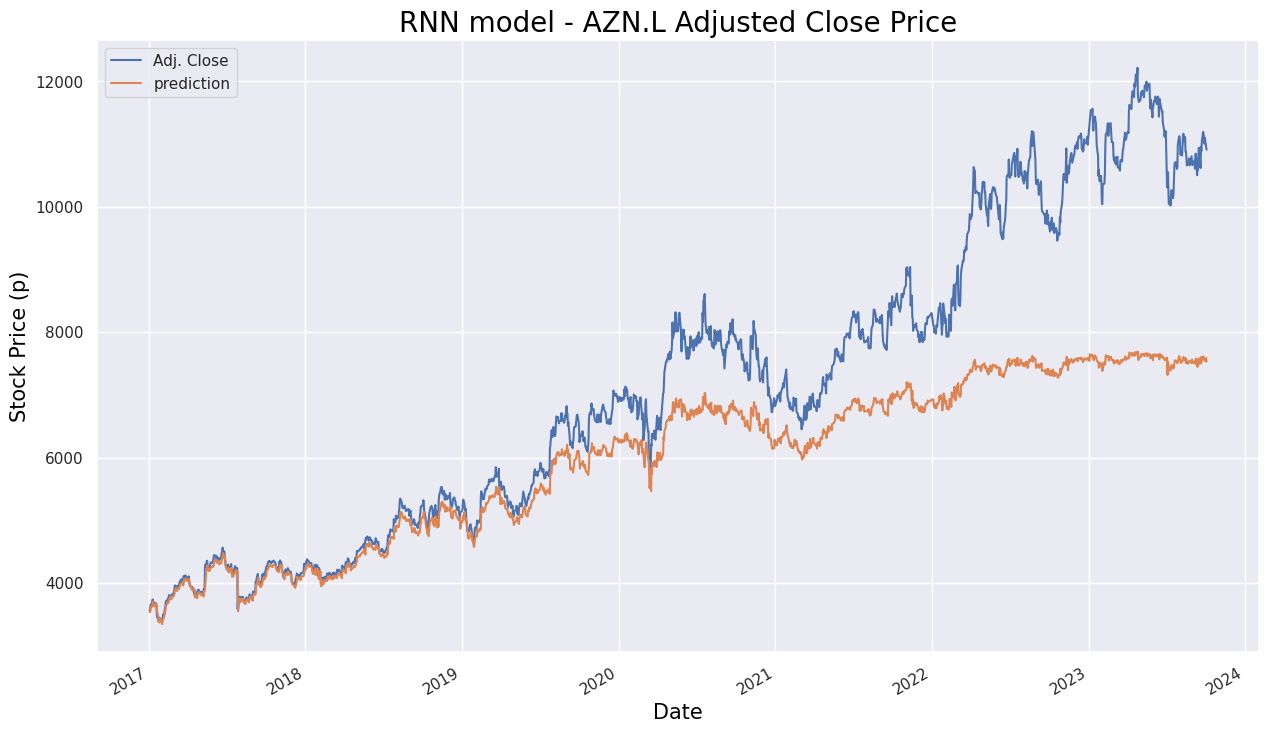

In [ ]:
title_txt = 'RNN model - AZN.L Adjusted Close Price'

actual_pred_plot(rnn_predictions)

In RNN to train the network you backpropagate through time and at each step the gradient is calculated and used to update weights in the network. If the effect of the previous layer on the current layer is small then the gradient value will be small and vice-versa. This makes the gradients exponentially shrink down as we backpropagate until they eventually vanish. It's too difficult for RNN to learn to preserve information over many time steps as the hidden state is constently being rewritten.

Long Short-Term Memory (LSTM) and Gated recurrent unit (GRU) models use a recursive structure where the information does not vanish quickly.

## 6. Long Short-Term Memory (LSTM)

LSTM structure retains memory for RNNs over longer time periods. It solves the problem of gradient vanishing (or gradient explosion) by introducing the concept of gates for controlling the flow of information in the network. Gates are capable of learning which inputs in the sequence are important and store their information in the memory unit. They can pass the information in long sequences and use them to make predictions. An LSTM has input, output and forget gates.

It is called Long Short-Term Memory because it uses the short-term memory processes to create longer memory. LSTM has its own layers called the cell state, often labelled *Ct*, in addition to the hidden layers to prevent information from vanishing too soon.

An LSTM model will be implemented comprising two recurrent layers with 50 neurons, input shape of data with number of time steps (5) and dimensionality (1), and an output layer with time step of 2, and the tanh activation function. Dropout will be used after the second hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimiser, then fitted on the training set for 200 epochs with a batch size of 150.  



In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    

    # The LSTM architecture
    my_LSTM_model = Sequential()
    # First LSTM layer
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # Second LSTM layer
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # Dropout regularisation
    my_LSTM_model.add(Dropout(0.2))
    # The output layer
    my_LSTM_model.add(Dense(units=2))

    # Compiling the LSTM
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')

    # Fitting the LSTM to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=200,batch_size=150, verbose=1)

    # Make Predictions using the test set
    LSTM_predictions = my_LSTM_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)

    return my_LSTM_model, LSTM_predictions

my_LSTM_model, LSTM_predictions = LSTM_model(X_train, y_train, X_test, sc)
LSTM_predictions[1:10]

Epoch 1/200
40/40 [==============================] - 5s 8ms/step - loss: 0.0431
Epoch 2/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 3/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 4/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 8/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 10/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 11/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 12/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 13/200
40/40 [=================

array([[3515.39  , 3516.9805],
       [3537.2974, 3538.906 ],
       [3587.188 , 3588.7998],
       [3603.2822, 3604.813 ],
       [3638.1   , 3639.6294],
       [3678.3384, 3679.876 ],
       [3640.2651, 3641.74  ],
       [3611.646 , 3613.187 ],
       [3634.422 , 3636.0962]], dtype=float32)

### Print MSE and plot LSTM model actual vs predictions

MSE score: 295755.06


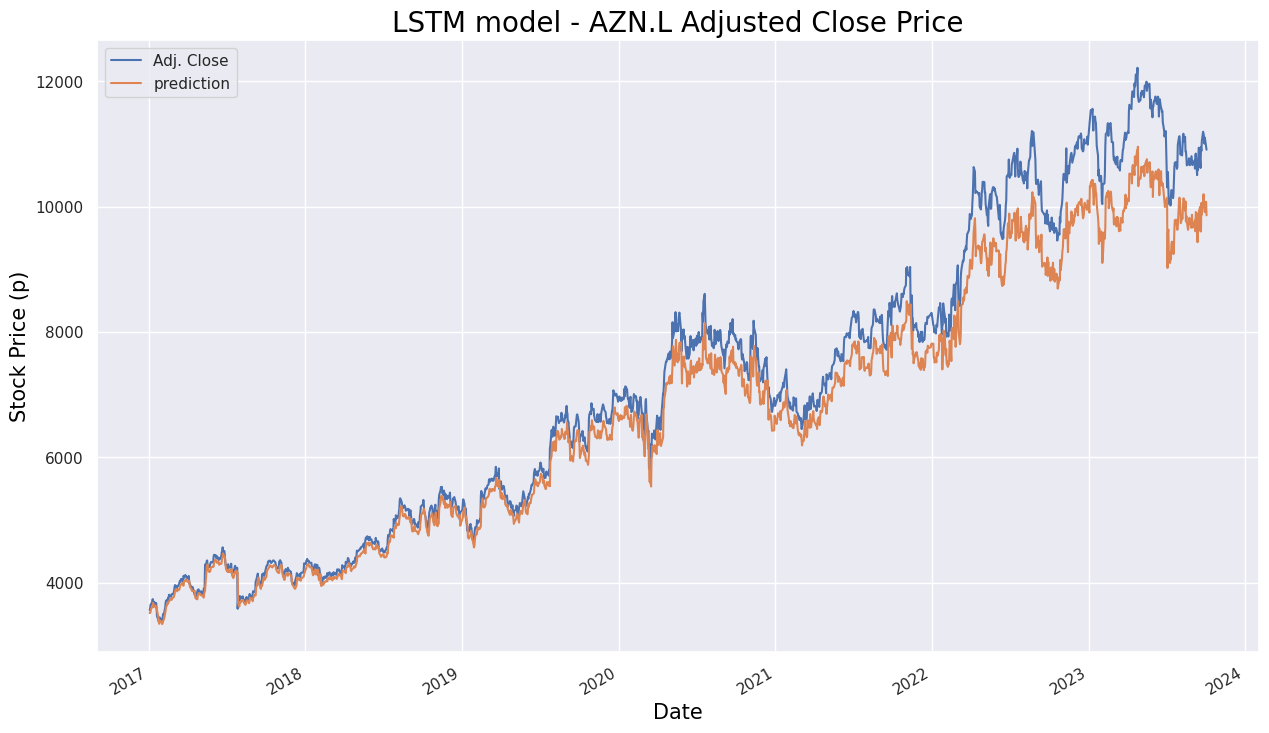

In [ ]:
title_txt = 'LSTM model - AZN.L Adjusted Close Price'

actual_pred_plot(LSTM_predictions)

The MSE is  lower than the Simple RNN score .

## Gated Recurrent Units (GRU)

GRU also aims to solve the vanishing gradient problem. It does not have the cell state and the output gate like those in LSTM and therefore has fewer parameters. It uses the hidden layers to transfer information and calls its two gates the reset gate and the update gate.

A GRU model will be implemented comprising four recurrent layers with 50 neurons, input shape of data with number of time steps (5) and dimensionality (1), and an output layer with time step of 2, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimiser, then fitted on the training set for 200 epochs with a batch size of 150.

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):
    

    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=60, return_sequences=True, activation='relu'))
    my_GRU_model.add(Dropout(0.3))
    # Third GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=80, return_sequences=True, activation='relu'))
    my_GRU_model.add(Dropout(0.4))
    # Fourth GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=120, activation='tanh'))
    my_GRU_model.add(Dropout(0.5))

    # The output layer
    my_GRU_model.add(Dense(units=2))

    # Compiling the GRU model
    my_GRU_model.compile(optimizer='adam',loss='mean_squared_error')

    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=200,batch_size=32, verbose=1)

    # Make Predictions using the test set
    GRU_predictions = my_GRU_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)
GRU_predictions[1:10]

Epoch 1/200
185/185 [==============================] - 16s 48ms/step - loss: 0.0141
Epoch 2/200
185/185 [==============================] - 9s 48ms/step - loss: 0.0040
Epoch 3/200
185/185 [==============================] - 8s 42ms/step - loss: 0.0033
Epoch 4/200
185/185 [==============================] - 9s 49ms/step - loss: 0.0027
Epoch 5/200
185/185 [==============================] - 9s 48ms/step - loss: 0.0024
Epoch 6/200
185/185 [==============================] - 10s 56ms/step - loss: 0.0022
Epoch 7/200
185/185 [==============================] - 9s 49ms/step - loss: 0.0022
Epoch 8/200
185/185 [==============================] - 9s 47ms/step - loss: 0.0018
Epoch 9/200
185/185 [==============================] - 8s 46ms/step - loss: 0.0018
Epoch 10/200
185/185 [==============================] - 8s 43ms/step - loss: 0.0016
Epoch 11/200
185/185 [==============================] - 9s 48ms/step - loss: 0.0015
Epoch 12/200
185/185 [==============================] - 9s 47ms/step - loss: 0.0014

array([[3051.3962, 3043.7043],
       [3070.4292, 3062.5183],
       [3109.9114, 3101.5435],
       [3132.5107, 3123.8801],
       [3156.5388, 3147.6138],
       [3193.983 , 3184.6587],
       [3192.4014, 3183.1375],
       [3162.822 , 3153.8943],
       [3177.9495, 3168.8992]], dtype=float32)

### Print MSE and plot GRU model actual vs predictions

MSE score: 2203350.8


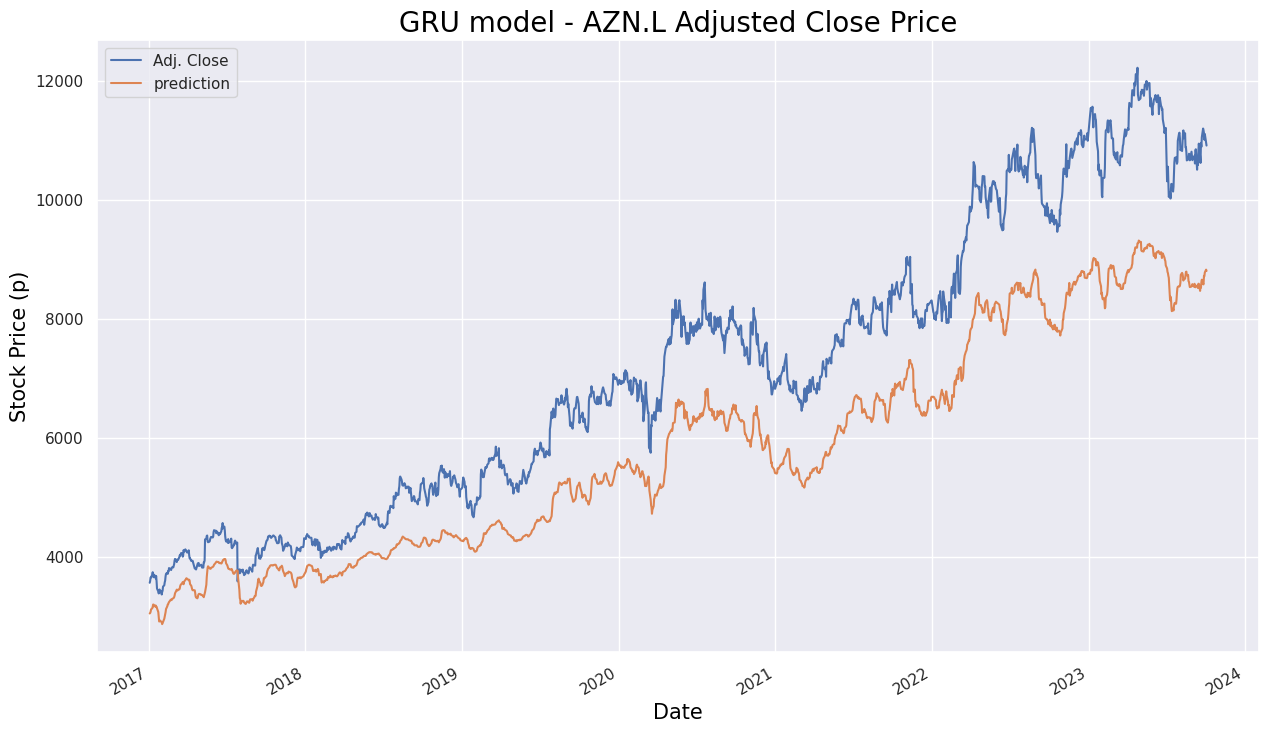

In [ ]:
title_txt = 'GRU model - AZN.L Adjusted Close Price'

actual_pred_plot(GRU_predictions)

As seen only LSTM performs well out of other two models.The LSTM cell adds long-term memory in an even more performant way because it allows even more parameters to be learned. This makes it the most powerful Recurent Neural Network to do forecasting, especially when you have a longer-term trend in your data.
Now we are using advanced stacked LSTM to build our final model.